<a href="https://colab.research.google.com/github/luisflorenz/jupyter_data/blob/main/trading_at_the_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trading-at-the-close



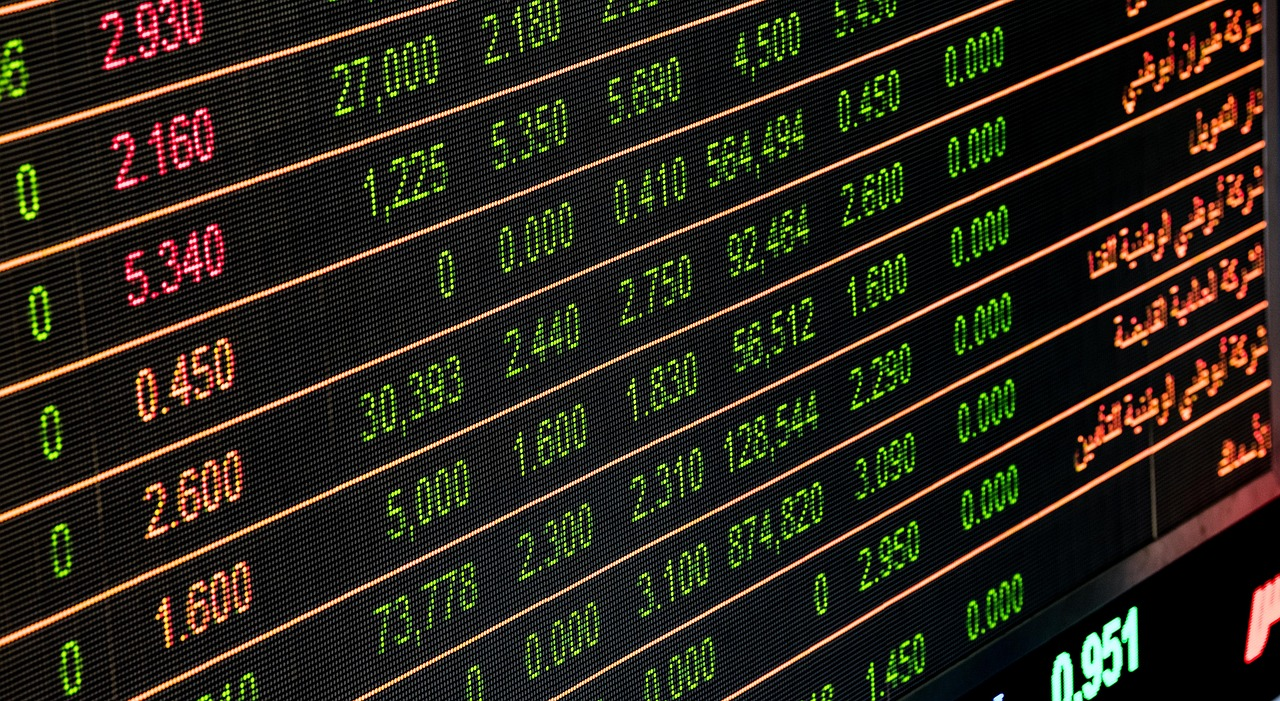

In this notebook we will try to develop a model capable of predicting the closing price movements of hundreds of shares listed on Nasdaq using data from the order book and the closing auction of the stock using pytorch.

In [2]:
!pip install jovian

In [3]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import csv
import os

## Download and explore the data

In [5]:
! pip install opendatasets --upgrade --quiet

In [6]:
import opendatasets as od

In [7]:
data_url = 'https://www.kaggle.com/competitions/optiver-trading-at-the-close'

In [8]:
od.download(data_url)

100%|██████████| 201M/201M [00:09<00:00, 21.9MB/s]



Extracting archive ./optiver-trading-at-the-close/optiver-trading-at-the-close.zip to ./optiver-trading-at-the-close


In [9]:
df_raw = pd.read_csv('/content/optiver-trading-at-the-close/train.csv')

In [10]:
df_raw.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [11]:
df_raw.shape

(5237980, 17)

In [12]:
df_raw.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [14]:
df_raw.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [15]:
df_raw.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

Let's make a copy to manipulate the dataframe

In [16]:
train_df = df_raw.copy()

In [17]:
train_df = train_df.fillna(0)

In [18]:
train_df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [19]:
train_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


<Axes: xlabel='target', ylabel='Count'>

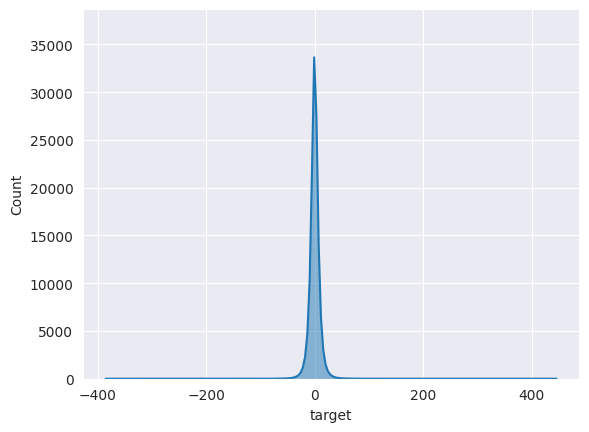

In [ ]:
sns.histplot(data=train_df, x='target', kde=True)

In [ ]:
train_df.corr()

<ipython-input-21-a7a80d20a44e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.corr()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
stock_id,1.000000e+00,5.028770e-03,-1.116655e-16,0.024638,0.004067,-0.000583,0.035129,-0.000277,0.000051,0.001247,0.032975,-0.002599,0.027150,-0.000536,0.000130,0.005029
date_id,5.028770e-03,1.000000e+00,1.280965e-14,0.006437,-0.010572,-0.004779,0.000520,-0.000555,-0.000195,-0.004782,0.024776,-0.004929,0.018673,-0.004892,0.000893,0.999998
seconds_in_bucket,-1.116655e-16,1.280965e-14,1.000000e+00,-0.123943,-0.003635,-0.000304,0.068623,0.613982,0.862521,0.005333,0.162867,-0.006436,0.146338,-0.000453,-0.002203,0.002083
imbalance_size,2.463751e-02,6.436509e-03,-1.239428e-01,1.000000,-0.010156,0.000329,0.512369,-0.095673,-0.132787,0.003733,0.021143,-0.002929,0.022626,0.000428,-0.001190,0.006178
imbalance_buy_sell_flag,4.066622e-03,-1.057243e-02,-3.634734e-03,-0.010156,1.000000,0.067468,-0.006000,0.002507,-0.000296,0.047828,0.035238,0.049041,-0.013352,0.049313,0.015102,-0.010580
reference_price,-5.825748e-04,-4.778645e-03,-3.038160e-04,0.000329,0.067468,1.000000,0.004758,0.005612,0.007067,0.997848,0.003358,0.998033,-0.000829,0.998433,-0.006763,-0.004779
matched_size,3.512907e-02,5.199416e-04,6.862336e-02,0.512369,-0.006000,0.004758,1.000000,0.052548,0.071222,0.010431,0.078554,-0.000676,0.079212,0.004928,0.000196,0.000663
far_price,-2.771004e-04,-5.546278e-04,6.139818e-01,-0.095673,0.002507,0.005612,0.052548,1.000000,0.708135,0.008784,0.102432,0.001874,0.092303,0.005343,-0.000121,0.000725
near_price,5.066162e-05,-1.948627e-04,8.625206e-01,-0.132787,-0.000296,0.007067,0.071222,0.708135,1.000000,0.011326,0.141925,0.002199,0.129045,0.006757,0.001008,0.001602
bid_price,1.246926e-03,-4.782358e-03,5.333216e-03,0.003733,0.047828,0.997848,0.010431,0.008784,0.011326,1.000000,0.000317,0.996478,-0.001494,0.998612,-0.008468,-0.004771


<ipython-input-22-72cd48f753c4>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, cmap='BuPu');


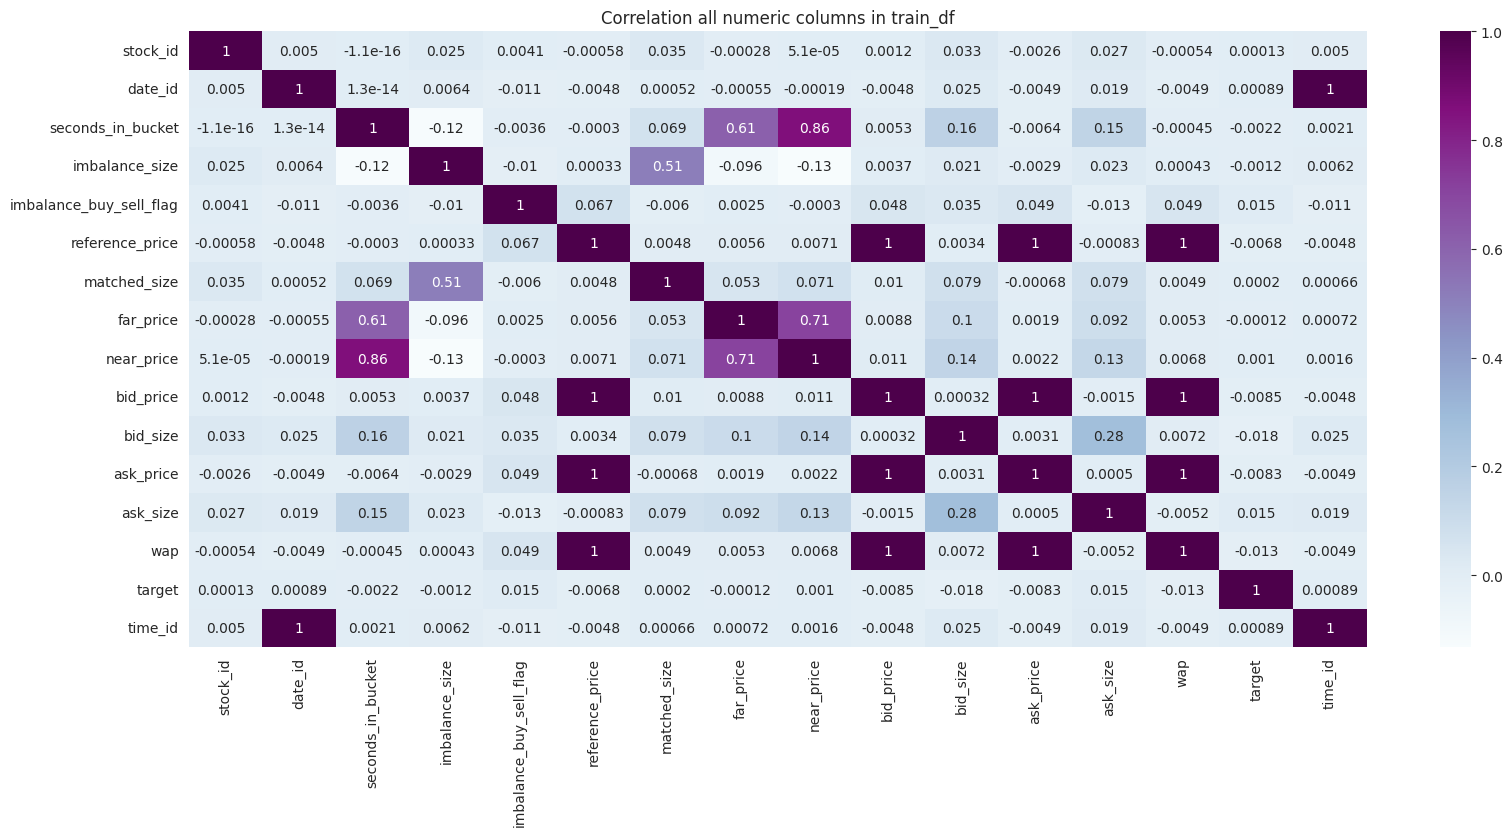

In [ ]:
plt.figure(figsize=(19,8))
plt.title('Correlation all numeric columns in train_df')
sns.heatmap(train_df.corr(), annot=True, cmap='BuPu');

## Input variables

In [20]:
train_df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [21]:
input_cols = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap','time_id', 'row_id']

In [22]:
categorical_cols = train_df.select_dtypes(include='object').columns.tolist()
categorical_cols

['row_id']

In [23]:
output_cols = ['target']

In [24]:
train_df[input_cols]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,1.000660,20605.09,1.000000,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,1.000298,18995.00,1.000000,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,1.000214,479032.40,1.000000,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,1.000016,434.10,1.000000,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198


In [25]:
train_df[output_cols]

,target
0,-3.029704
1,-5.519986
2,-8.389950
3,-4.010200
4,-7.349849
...,...
5237975,2.310276
5237976,-8.220077
5237977,1.169443
5237978,-1.540184


## Prepare the dataset for training

In [26]:
def dataframe_to_arrays(train_df):
    # Make a copy of the original dataframe
    dataframe1 = train_df.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy().astype(np.float)
    targets_array = dataframe1[output_cols].to_numpy().astype(np.float)
    return inputs_array, targets_array

In [27]:
inputs_array, targets_array = dataframe_to_arrays(train_df)
inputs_array, targets_array

<ipython-input-26-28bc4539e086>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inputs_array = dataframe1[input_cols].to_numpy().astype(np.float)
<ipython-input-26-28bc4539e086>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  targets_array = dataframe1[output_cols].to_numpy().astype(np.float)


(array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
         0.000000e+00, 1.000000e+00],
        [2.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
         0.000000e+00, 1.060000e+02],
        ...,
        [1.970000e+02, 4.800000e+02, 5.400000e+02, ..., 9.957970e-01,
         2.645400e+04, 4.614324e+06],
        [1.980000e+02, 4.800000e+02, 5.400000e+02, ..., 9.990080e-01,
         2.645400e+04, 4.614325e+06],
        [1.990000e+02, 4.800000e+02, 5.400000e+02, ..., 1.002274e+00,
         2.645400e+04, 4.614326e+06]]),
 array([[-3.029704 ],
        [-5.519986 ],
        [-8.38995  ],
        ...,
        [ 1.1694431],
        [-1.540184 ],
        [-6.530285 ]]))

In [28]:
inputs_array.shape, targets_array.shape

((5237980, 16), (5237980, 1))

## Convert the numpy arrays inputs_array and targets_array into PyTorch tensors

In [29]:
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [30]:
inputs, targets

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
          1.0000e+00],
         [2.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
          1.0600e+02],
         ...,
         [1.9700e+02, 4.8000e+02, 5.4000e+02,  ..., 9.9580e-01, 2.6454e+04,
          4.6143e+06],
         [1.9800e+02, 4.8000e+02, 5.4000e+02,  ..., 9.9901e-01, 2.6454e+04,
          4.6143e+06],
         [1.9900e+02, 4.8000e+02, 5.4000e+02,  ..., 1.0023e+00, 2.6454e+04,
          4.6143e+06]]),
 tensor([[-3.0297],
         [-5.5200],
         [-8.3899],
         ...,
         [ 1.1694],
         [-1.5402],
         [-6.5303]]))

In [31]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [32]:
inputs.shape, targets.shape

(torch.Size([5237980, 16]), torch.Size([5237980, 1]))

### We will created PyTorch datasets and dataloaders for training & validation.

In [33]:
dataset = TensorDataset(inputs, targets )

In [34]:
dataset

We will choose a percentage to determine the fraction of data that will be used to create the validation set. Then use random_split to create training and validation data sets.

In [35]:
num_rows = train_df.shape[0]
num_rows

5237980

In [36]:
val_percent = 1.5
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

In [37]:
train_ds , val_ds = random_split(dataset, [train_size, val_size])

In [38]:
len(train_ds),len(val_ds)

(2618990, 2618990)

Finally, we can create data loaders for training & validation

In [39]:
batch_size = 512

In [40]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [41]:
for xb, yb in train_dl:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[1.5900e+02, 2.2300e+02, 2.2000e+02,  ..., 1.0005e+00, 1.2287e+04,
         1.4875e+06],
        [8.2000e+01, 2.7000e+01, 3.5000e+02,  ..., 9.9798e-01, 1.5200e+03,
         2.1669e+06],
        [1.9400e+02, 3.8600e+02, 2.4000e+02,  ..., 9.9917e-01, 2.1254e+04,
         3.4565e+06],
        ...,
        [6.2000e+01, 3.2100e+02, 3.0000e+02,  ..., 1.0008e+00, 1.7685e+04,
         2.6793e+06],
        [1.6000e+01, 3.6500e+02, 3.4000e+02,  ..., 1.0007e+00, 2.0109e+04,
         3.2064e+06],
        [4.0000e+00, 8.5000e+01, 3.3000e+02,  ..., 9.9572e-01, 4.7080e+03,
         5.0599e+06]])
targets: tensor([[-4.7600e+00],
        [-7.0500e+00],
        [ 8.7595e+00],
        [-1.2398e+00],
        [-2.9498e+00],
        [-2.4974e-01],
        [ 2.8460e+01],
        [-2.0999e+00],
        [ 2.1398e+00],
        [ 7.5603e+00],
        [-2.9802e-02],
        [-1.3080e+01],
        [ 5.2905e+00],
        [-6.8009e-01],
        [-4.2301e+00],
        [-1.6600e+00],
        [ 8.0204e+0

## Let's create a Linear Regression Model

In [42]:
input_size = len(input_cols)
output_size = len(output_cols)

In [43]:
class MarketModel(nn.Module):
    def __init__(self, input_size, output_size, loss_fn):
        super().__init__()
        self.loss_fn = loss_fn
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)

    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calcuate loss
        loss = self.loss_fn(out, targets)                          # fill this
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = self.loss_fn(out, targets)                           # fill this
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [44]:
model = MarketModel(input_size, output_size, F.smooth_l1_loss)

In [45]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2382, -0.1190,  0.0719,  0.1069,  0.0496, -0.0403, -0.2362, -0.2032,
           0.1965, -0.0973,  0.0163, -0.1373,  0.1511,  0.2167, -0.0286, -0.0110]],
        requires_grad=True),
 Parameter containing:
 tensor([0.0402], requires_grad=True)]

## Let's train the model to fit the data

In [59]:
def evaluate(model, val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, val_dl, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_dl)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [47]:
result = evaluate(model, val_dl)
print(result)

{'val_loss': 10073082.0}


##  Train the model 4-5 times with different learning rates & for different number of epochs.

In [48]:
epochs = 10
lr = 1e-2
history1 = fit(epochs, lr, model, train_dl, val_dl)

Epoch [1], val_loss: 119859.8750
Epoch [2], val_loss: 68406.7969
Epoch [3], val_loss: 36336.6367
Epoch [4], val_loss: 191705.9375
Epoch [5], val_loss: 49667.2930
Epoch [6], val_loss: 60061.0898
Epoch [7], val_loss: 7831.6699
Epoch [8], val_loss: 28060.0625
Epoch [9], val_loss: 25366.8691
Epoch [10], val_loss: 17266.7168


In [49]:
epochs = 10
lr = 1e-3
history2 = fit(epochs, lr, model, train_dl, val_dl)

Epoch [1], val_loss: 8849.0176
Epoch [2], val_loss: 851.2674
Epoch [3], val_loss: 5371.6860
Epoch [4], val_loss: 5814.8970
Epoch [5], val_loss: 6148.6265
Epoch [6], val_loss: 6534.8843
Epoch [7], val_loss: 5352.7783
Epoch [8], val_loss: 7963.2510
Epoch [9], val_loss: 2734.4070
Epoch [10], val_loss: 5936.4854


In [50]:
epochs = 10
lr = 1e-4
history3 = fit(epochs, lr, model, train_dl, val_dl)

Epoch [1], val_loss: 182.4731
Epoch [2], val_loss: 637.7438
Epoch [3], val_loss: 852.7479
Epoch [4], val_loss: 454.1210
Epoch [5], val_loss: 931.0849
Epoch [6], val_loss: 723.3364
Epoch [7], val_loss: 497.6494
Epoch [8], val_loss: 456.5197
Epoch [9], val_loss: 1055.5697
Epoch [10], val_loss: 146.2528


In [51]:
epochs = 10
lr = 1e-5
history4 = fit(epochs, lr, model, train_dl, val_dl)

Epoch [1], val_loss: 39.6073
Epoch [2], val_loss: 55.3066
Epoch [3], val_loss: 30.1173
Epoch [4], val_loss: 38.8626
Epoch [5], val_loss: 82.5762
Epoch [6], val_loss: 106.8011
Epoch [7], val_loss: 91.0477
Epoch [8], val_loss: 59.5778
Epoch [9], val_loss: 21.3672
Epoch [10], val_loss: 14.7024


In [52]:
epochs = 10
lr = 1e-6
history5 = fit(epochs, lr, model, train_dl, val_dl)

Epoch [1], val_loss: 7.2432
Epoch [2], val_loss: 9.7882
Epoch [3], val_loss: 6.3286
Epoch [4], val_loss: 7.6261
Epoch [5], val_loss: 7.6341
Epoch [6], val_loss: 6.4640
Epoch [7], val_loss: 9.6478
Epoch [8], val_loss: 7.7750
Epoch [9], val_loss: 10.5064
Epoch [10], val_loss: 8.0164


In [55]:
epochs = 30
lr = 1e-7
history6 = fit(epochs, lr, model, train_dl, val_dl)

Epoch [1], val_loss: 6.4219
Epoch [2], val_loss: 6.0288
Epoch [3], val_loss: 6.1750
Epoch [4], val_loss: 6.0942
Epoch [5], val_loss: 5.9401
Epoch [6], val_loss: 6.1024
Epoch [7], val_loss: 6.0961
Epoch [8], val_loss: 5.9611
Epoch [9], val_loss: 6.0484
Epoch [10], val_loss: 6.0582
Epoch [11], val_loss: 5.9645
Epoch [12], val_loss: 5.9493
Epoch [13], val_loss: 6.4339
Epoch [14], val_loss: 6.1982
Epoch [15], val_loss: 5.9459
Epoch [16], val_loss: 6.0056
Epoch [17], val_loss: 6.1601
Epoch [18], val_loss: 6.1846
Epoch [19], val_loss: 6.1681
Epoch [20], val_loss: 6.5454
Epoch [21], val_loss: 6.4036
Epoch [22], val_loss: 5.9488
Epoch [23], val_loss: 5.9464
Epoch [24], val_loss: 6.0852
Epoch [25], val_loss: 6.0571
Epoch [26], val_loss: 5.9939
Epoch [27], val_loss: 6.7506
Epoch [28], val_loss: 6.0632
Epoch [29], val_loss: 5.9357
Epoch [30], val_loss: 5.9445


In [60]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

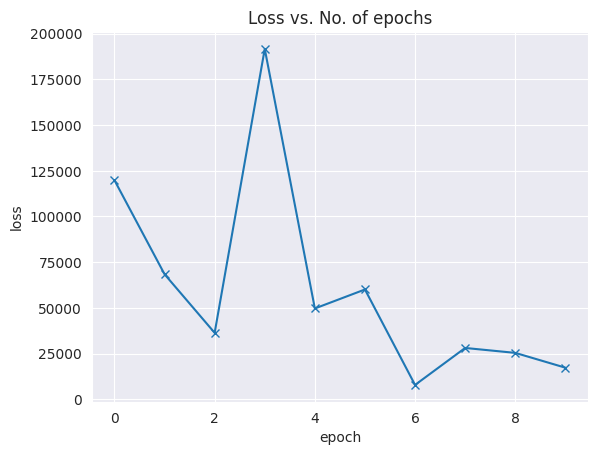

In [65]:
plot_losses(history1)

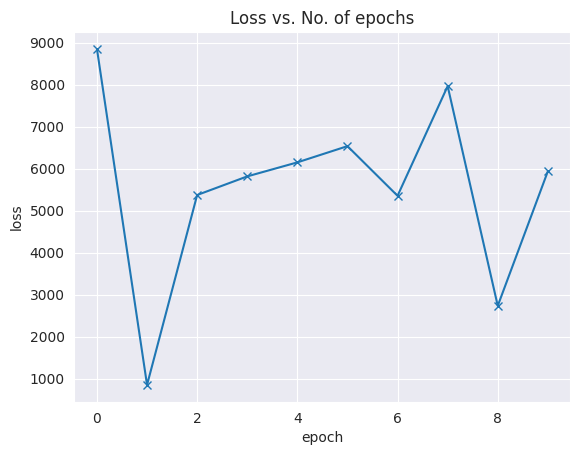

In [66]:
plot_losses(history2)

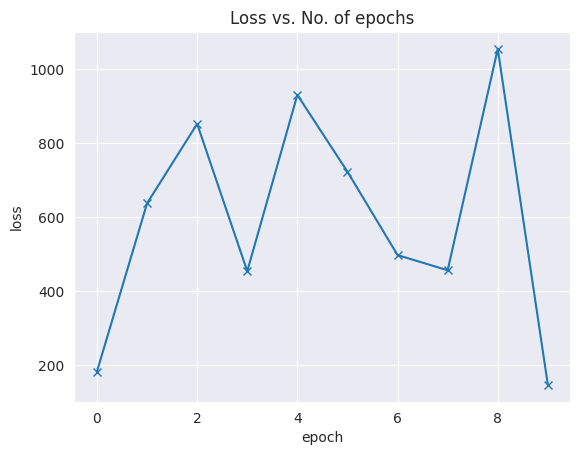

In [67]:
plot_losses(history3)

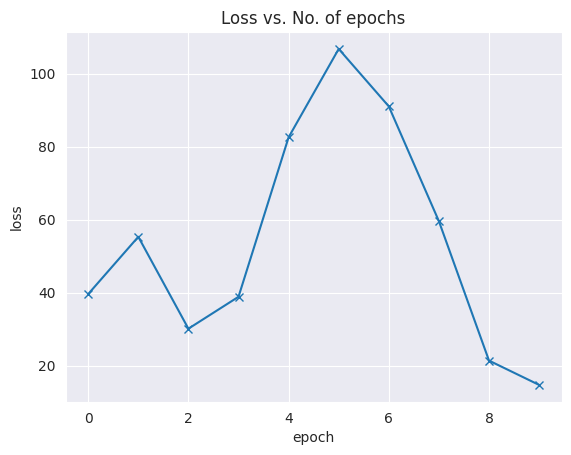

In [68]:
plot_losses(history4)

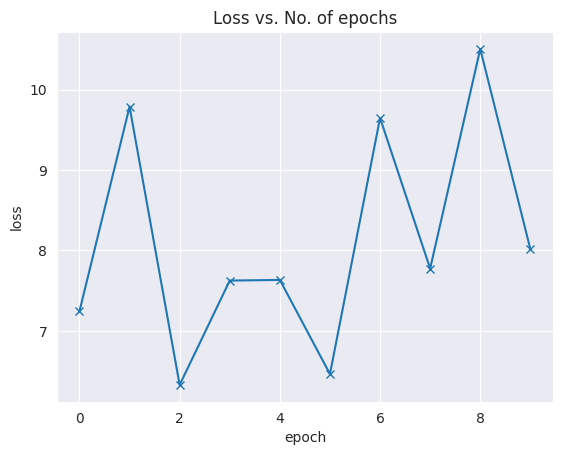

In [69]:
plot_losses(history5)

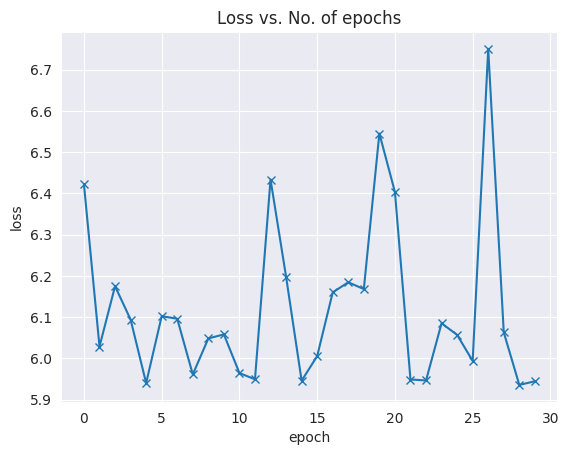

In [70]:
plot_losses(history6)

## What is the final validation loss of your model?

In [71]:
import jovian

In [72]:
val_loss = history6[-1]['val_loss']

In [73]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Metrics logged.


In [74]:
project_name = 'Trading at the Close'

In [75]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [ ]:
jovian.commit(project = project_name)


[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


## Make predictions using the trained model
make predictions on a single input

In [76]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [77]:
input, target = val_ds[3]
predict_single(input, target, model)

Input: tensor([ 6.2000e+01,  1.8500e+02,  8.0000e+01,  9.6968e+05, -1.0000e+00,
         9.9844e-01,  3.5369e+06,  0.0000e+00,  0.0000e+00,  9.9819e-01,
         3.1188e+04,  9.9953e-01,  6.2460e+03,  9.9931e-01,  1.0183e+04,
         1.0268e+06])
Target: tensor([31.3699])
Prediction: tensor(-0.0340)


In [78]:
input, target = val_ds[9]
predict_single(input, target, model)

Input: tensor([1.5300e+02, 2.5800e+02, 2.0000e+02, 5.7798e+05, 1.0000e+00, 1.0015e+00,
        5.7293e+05, 0.0000e+00, 0.0000e+00, 1.0011e+00, 1.7295e+04, 1.0015e+00,
        1.0898e+04, 1.0014e+00, 1.4210e+04, 1.9017e+06])
Target: tensor([4.8101])
Prediction: tensor(-0.1942)


In [79]:
input, target = val_ds[369]
predict_single(input, target, model)

Input: tensor([ 5.1000e+01,  4.0800e+02,  4.2000e+02,  6.7755e+06, -1.0000e+00,
         9.9957e-01,  8.1185e+06,  9.5269e-01,  9.6982e-01,  9.9957e-01,
         6.6169e+03,  9.9973e-01,  7.6694e+03,  9.9964e-01,  2.2482e+04,
         3.7344e+06])
Target: tensor([-10.5602])
Prediction: tensor(-0.1637)
